In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import json
from utils import *

import seaborn as sns
from collections import Counter

In [3]:
## read training data
data = pd.read_csv('../data/train.csv', converters={'POLYLINE': lambda x: json.loads(x)})

In [4]:
data.head()

,TRIP_ID,CALL_TYPE,ORIGIN_CALL,ORIGIN_STAND,TAXI_ID,TIMESTAMP,DAY_TYPE,MISSING_DATA,POLYLINE
0,1372636858620000589,C,NaN,NaN,20000589,1372636858,A,False,"[[-8.618643, 41.141412], [-8.618499, 41.141376..."
1,1372637303620000596,B,NaN,7.0,20000596,1372637303,A,False,"[[-8.639847, 41.159826], [-8.640351, 41.159871..."
2,1372636951620000320,C,NaN,NaN,20000320,1372636951,A,False,"[[-8.612964, 41.140359], [-8.613378, 41.14035]..."
3,1372636854620000520,C,NaN,NaN,20000520,1372636854,A,False,"[[-8.574678, 41.151951], [-8.574705, 41.151942..."
4,1372637091620000337,C,NaN,NaN,20000337,1372637091,A,False,"[[-8.645994, 41.18049], [-8.645949, 41.180517]..."


In [33]:
polyline = data['POLYLINE'].values
polyline.shape

(1710670,)

In [35]:
# exploring trip length and the destination points
ls_end = []
trip_length = []
for p in polyline:
    if len(p) > 0:
        ls_end.append(p[-1])
        trip_length.append(len(p))

In [36]:
# Calculate the center of all end point of trips
CITY_CENTER = np.mean(ls_end, axis=0)
CITY_CENTER

array([-8.62005913, 41.16232642])

In [37]:
# explore data

In [38]:
sns.set(color_codes=True)

C:\ProgramData\Anaconda3\lib\site-packages\matplotlib\axes\_axes.py:6462: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "


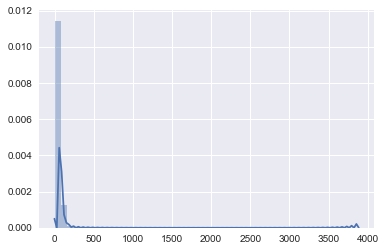

In [39]:
# plot distribution of trip length
sns.distplot(trip_length)

In [42]:
# choose different length to see the distribution
length_mask = np.array(trip_length) <= 189
remain_length = np.array(trip_length)[length_mask]
print(len(remain_length)/len(trip_length))

0.990016242669828


C:\ProgramData\Anaconda3\lib\site-packages\matplotlib\axes\_axes.py:6462: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "


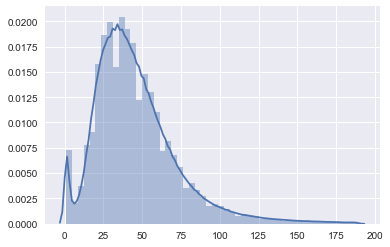

In [43]:
# plot new distribution
sns.distplot(remain_length)

In [2]:
# Trip length that contains 99% number of trips
TRIP_LENGTH_99 = 189

CITY_CENTER = np.array([[-8.62005913, 41.16232642]], ndmin=2)

In [4]:
# release memory for data
del data

## Some helper function

In [5]:
# calculate rmse
def rmse(y_true, y_pred):
    return np.sqrt(np.mean((y_true - y_pred)**2))

# calculate haversine distance between two points
def haversine_distance(p1, p2):
    r = 6371
    p1 = np.array(p1, ndmin=2)
    p2 = np.array(p2, ndmin=2)
    p1 = np.radians(p1)
    p2 = np.radians(p2)
    dlon = abs(p2[:,0] - p1[:,0])
    dlat = abs(p2[:,1] - p1[:,1])
    a = np.sin(dlat)**2 + np.cos(p1[:,1])*np.cos(p2[:,1])*np.sin(dlon)**2
    c = 2 * r * np.arctan2(np.sqrt(a), np.sqrt(1 - a))
    return c

def heading(p1, p2):
    p1 = np.radians(p1)
    p2 = np.radians(p2)
    lat1, lon1 = p1[1], p1[0]
    lat2, lon2 = p2[1], p2[0]
    aa = np.sin(lon2 - lon1) * np.cos(lat2)
    bb = np.cos(lat1) * np.sin(lat2) - np.sin(lat1) * np.cos(lat2) * np.cos(lon2 - lon1)
    return np.arctan2(aa, bb) + np.pi 

## Process data
we will create 4 models with 4 different traning sets

In [6]:
import time

#### create training set 1
Only using the starting point of POLYLINE to produce data set, we will use the following features: 
- week day, hour (from TIMESTAMP)
- trip start point (xs, ys)
- haversine distance and heading from the start point to CITY_CENTER calculated above
- trip length as the predict target

In [7]:
def process_row(row):
    x = row['POLYLINE']
    # only keep trip with length > 4 (drop short trip)
    if len(x)>4:
        x = np.array(x, ndmin=2)
        
        # process trip
        data = process_trip(x[0, :], row['TIMESTAMP'])
        
        # add end point and trip length
        data += [x[-1,0], x[-1,1], len(x)]
    else:
        data = [-1]*9
    return pd.Series(np.array(data, dtype=float))

def process_row_test(row):
    x = row['POLYLINE']
    x = np.array(x, ndmin=2)
    
    data = process_trip(x[0, :], row['TIMESTAMP'])
    
    return pd.Series(np.array(data, dtype=float))

# process trip, add week day, hour, haversine distance, head distance, start point
def process_trip(x, start_time):
    # process time
    tt = time.localtime(start_time)
    data = [tt.tm_wday, tt.tm_hour]
    
    # distance from the center to the first point
    d_st = haversine_distance(x,  CITY_CENTER)
    head = heading(x,  CITY_CENTER[0])
    data += [x[0], x[1], d_st, head]
    return data

In [8]:
# features list
FEATURES = ['wday','hour','xs','ys','d_st','heading']

In [9]:
%%time
### Create training set
print('reading training data ...')
df = pd.read_csv('../data/train.csv', converters={'POLYLINE': lambda x: json.loads(x)})

print('preparing train data ...')
ds = df.apply(process_row, axis=1)
ds.columns = FEATURES + ['xe','ye','len']
# drop unused features
df.drop(['POLYLINE','TIMESTAMP','TRIP_ID','DAY_TYPE','ORIGIN_CALL','ORIGIN_STAND'], axis=1, inplace=True)

# transform ID to smaller
df['TAXI_ID'] -= np.min(df['TAXI_ID'])   
df = df.join(ds)

# clean up and save to file
df = df[(df['xe'] != -1) & (df['MISSING_DATA']==False)]
df.drop(['MISSING_DATA'], axis=1, inplace=True)
df.to_csv('../data/train_set_1.csv', index=False)

reading training data ...
preparing train data ...
Wall time: 7min 56s


In [10]:
%%time
# Process test set 1
print('reading test data ...')
df = pd.read_csv('../data/test.csv', converters={'POLYLINE': lambda x: json.loads(x)})

print('preparing test data ...')
ds = df.apply(process_row_test, axis=1)
ds.columns = FEATURES
df.drop(['POLYLINE','TIMESTAMP','DAY_TYPE','ORIGIN_CALL','ORIGIN_STAND', 'MISSING_DATA'], axis=1, inplace=True)
df = df.join(ds)
df.to_csv('../data/test_set_1.csv', index=False)

reading test data ...
preparing test data ...
Wall time: 151 ms


In [11]:
df.head()

,TRIP_ID,CALL_TYPE,TAXI_ID,wday,hour,xs,ys,d_st,heading
0,T1,B,20000542,4.0,0.0,-8.585676,41.148522,6.524594,2.060876
1,T2,B,20000108,4.0,0.0,-8.610876,41.145570,4.031250,2.750289
2,T3,B,20000370,4.0,0.0,-8.585739,41.148558,6.511518,2.060553
3,T4,B,20000492,4.0,0.0,-8.613963,41.141169,4.814657,2.927984
4,T5,B,20000621,4.0,0.0,-8.619903,41.148036,3.178152,3.133368


#### create training set 2
Only use first two points of POLYLINE to produce data set, we will use the following features: 
- week day, hour (from TIMESTAMP)
- trip start point (xs, ys)
- haversine distance and heading from the start point to CITY_CENTER calculated above
- haversine distance and heading from the start point to the second point
- trip length as the predict target

In [12]:
def process_row(row):
    x = row['POLYLINE']
    if len(x)>4:
        x = np.array(x, ndmin=2)
        data = process_trip(x[:2, :], row['TIMESTAMP'])
        data += [x[-1,0], x[-1,1], len(x)]
    else:
        data = [-1]*11
    return pd.Series(np.array(data, dtype=float))

def process_row_test(row):
    x = row['POLYLINE']
    x = np.array(x, ndmin=2)
    data = process_trip(x[:2, :], row['TIMESTAMP'])
    return pd.Series(np.array(data, dtype=float))

# add week day, hour, haversine distance and head distance between start point and CENTER, 
# haversine distance and head distance between start point and second point
def process_trip(x, start_time):
    tt = time.localtime(start_time)
    data = [tt.tm_wday, tt.tm_hour]
    
    # distance between 2 first points of trip
    v_mn = 0
    head = 0
    if len(x)>1:
        v_mn = haversine_distance(x[0,:], x[1,:])[0]
        head = heading(x[0,:], x[1,:])
        
    # distance from the center to the first point
    d_st = haversine_distance(x[0,:],  CITY_CENTER)
    h_st = heading(x[0,:],  CITY_CENTER[0])
    data += [x[-1,0], x[-1,1], d_st, h_st, v_mn, head]
    return data

In [13]:
FEATURES = ['wday','hour','xs','ys','d_st','h_st','v_car','heading']

In [14]:
%%time
### Create training set

print('reading training data ...')
df = pd.read_csv('../data/train.csv', converters={'POLYLINE': lambda x: json.loads(x)})#, nrows=100)

print('preparing train data ...')
ds = df.apply(process_row, axis=1)
ds.columns = FEATURES + ['xe','ye','len']
df.drop(['POLYLINE','TIMESTAMP','TRIP_ID','DAY_TYPE','ORIGIN_CALL','ORIGIN_STAND'], axis=1, inplace=True)

# makes csv smaller -> ids in [0, 980]
df['TAXI_ID'] -= np.min(df['TAXI_ID'])   
df = df.join(ds)

# clean up tracks
df = df[(df['xe'] != -1) & (df['MISSING_DATA']==False)]
df.drop(['MISSING_DATA'], axis=1, inplace=True)
df.to_csv('../data/train_set_2.csv', index=False)

reading training data ...
preparing train data ...


In [15]:
%%time
### Process test set

print('reading test data ...')
df = pd.read_csv('../data/test.csv', converters={'POLYLINE': lambda x: json.loads(x)})

print('preparing test data ...')
ds = df.apply(process_row_test, axis=1)
ds.columns = FEATURES
df.drop(['POLYLINE','TIMESTAMP','DAY_TYPE','ORIGIN_CALL','ORIGIN_STAND',
         'MISSING_DATA'], axis=1, inplace=True)
df = df.join(ds)
df.to_csv('../data/test_set_2.csv', index=False)

reading test data ...
preparing test data ...
Wall time: 179 ms


In [16]:
df.head()

,TRIP_ID,CALL_TYPE,TAXI_ID,wday,hour,xs,ys,d_st,h_st,v_car,heading
0,T1,B,20000542,4.0,0.0,-8.585712,41.148639,6.524594,2.060876,0.026709,2.913916
1,T2,B,20000108,4.0,0.0,-8.610858,41.145579,4.031250,2.750289,0.003618,4.126252
2,T3,B,20000370,4.0,0.0,-8.585730,41.148828,6.511518,2.060553,0.060064,3.166687
3,T4,B,20000492,4.0,0.0,-8.614125,41.141124,4.814657,2.927984,0.028919,1.217429
4,T5,B,20000621,4.0,0.0,-8.619894,41.148036,3.178152,3.133368,0.001507,4.712389


#### create training set 3
Only use three initial points of POLYLINE to produce data set, we will use the following features: 
- week day, hour (from TIMESTAMP)
- trip start point (xs, ys)
- haversine distance and heading from the start point to CITY_CENTER calculated above
- haversine distance and heading from the start point to the third point
- trip length as the predict target

In [28]:
def process_row(row):
    x = row['POLYLINE']
    if len(x)>4:
        x = np.array(x, ndmin=2)
        data = process_trip(x[:3, :], row['TIMESTAMP'])
        data += [x[-1,0], x[-1,1], len(x)]
    else:
        data = [-1]*11
    return pd.Series(np.array(data, dtype=float))

def process_row_test(row):
    x = row['POLYLINE']
    x = np.array(x, ndmin=2)
    data = process_trip(x[:3, :], row['TIMESTAMP'])
    return pd.Series(np.array(data, dtype=float))

# add week day, hour, haversine distance and head distance between start point and CENTER, 
# haversine distance and head distance between starting point and the third point
def process_trip(x, start_time):
    # process time
    tt = time.localtime(start_time)
    data = [tt.tm_wday, tt.tm_hour]
    
    # distance from the first point and the third point
    v_mn = 0
    head = 0
    if len(x)>1:
        v_mn = haversine_distance(x[0,:], x[-1,:])[0]
        head = heading(x[0,:], x[-1,:])
        
    # distance from the center to the first point
    d_st = haversine_distance(x[0,:],  CITY_CENTER)
    h_st = heading(x[0,:],  CITY_CENTER[0])
    data += [x[-1,0], x[-1,1], d_st, h_st, v_mn, head]
    return data

In [29]:
FEATURES = ['wday','hour','xs','ys','d_st','h_st','v_car','heading']

In [20]:
%%time
### Process train set

print('reading training data ...')
df = pd.read_csv('../data/train.csv', converters={'POLYLINE': lambda x: json.loads(x)})#, nrows=100)

print('preparing train data ...')
ds = df.apply(process_row, axis=1)
ds.columns = FEATURES + ['xe','ye','len']
df.drop(['POLYLINE','TIMESTAMP','TRIP_ID','DAY_TYPE','ORIGIN_CALL','ORIGIN_STAND'], axis=1, inplace=True)

# makes csv smaller -> ids in [0, 980]
df['TAXI_ID'] -= np.min(df['TAXI_ID'])   
df = df.join(ds)

# clean up tracks
df = df[(df['xe'] != -1) & (df['MISSING_DATA']==False)]
df.drop(['MISSING_DATA'], axis=1, inplace=True)
df.to_csv('../data/train_set_3.csv', index=False)

reading training data ...
preparing train data ...
Wall time: 20min 20s


In [21]:
df.head()

,CALL_TYPE,TAXI_ID,wday,hour,xs,ys,d_st,h_st,v_car,heading,xe,ye,len
0,C,588,0.0,7.0,-8.620326,41.142510,4.657196,3.090661,0.372926,2.284696,-8.630838,41.154489,23.0
1,B,595,0.0,7.0,-8.642196,41.160114,3.359403,4.545984,0.398478,1.732242,-8.665740,41.170671,19.0
2,C,319,0.0,7.0,-8.614215,41.140278,5.027729,2.903066,0.210293,1.485039,-8.615970,41.140530,65.0
3,C,519,0.0,7.0,-8.574696,41.151933,7.941178,1.865869,0.005011,0.645397,-8.607996,41.142915,43.0
4,C,336,0.0,7.0,-8.646048,41.180049,5.930083,5.461600,0.098490,0.091901,-8.687268,41.178087,29.0


In [30]:
%%time
### Process test set

print('reading test data ...')
df = pd.read_csv('../data/test.csv', converters={'POLYLINE': lambda x: json.loads(x)})

print('preparing test data ...')
ds = df.apply(process_row_test, axis=1)
ds.columns = FEATURES
df.drop(['POLYLINE','TIMESTAMP','DAY_TYPE','ORIGIN_CALL','ORIGIN_STAND',
         'MISSING_DATA'], axis=1, inplace=True)
df = df.join(ds)
df.to_csv('../data/test_set_3.csv', index=False)

reading test data ...
preparing test data ...
Wall time: 104 ms


In [31]:
df.head()

,TRIP_ID,CALL_TYPE,TAXI_ID,wday,hour,xs,ys,d_st,h_st,v_car,heading
0,T1,B,20000542,4.0,0.0,-8.585685,41.148855,6.524594,2.060876,0.074071,3.121244
1,T2,B,20000108,4.0,0.0,-8.610903,41.145768,4.031250,2.750289,0.044265,3.039264
2,T3,B,20000370,4.0,0.0,-8.585721,41.148972,6.511518,2.060553,0.092119,3.174320
3,T4,B,20000492,4.0,0.0,-8.615088,41.140926,4.814657,2.927984,0.196012,1.291484
4,T5,B,20000621,4.0,0.0,-8.619894,41.148036,3.178152,3.133368,0.001507,4.712389


#### create training set 4
Use random number of initial points of POLYLINE to produce data set, we will use the following features: 
- week day, hour (from TIMESTAMP)
- trip start point (xs, ys)
- haversine distance and heading from the start point to CITY_CENTER calculated above
- haversine distance and heading from the start point to the third point
- trip length as the predict target

In [32]:
MAX_SAMPLES_PER_TRIP = 3
def process_row(X, row):
    pln = row['POLYLINE']
    if len(pln) > 4:
        pln = np.array(pln, ndmin=2)
        
        # calculate number of samples
        n_samples = min(int(1./TRIP_LENGTH_99 * len(pln) * MAX_SAMPLES_PER_TRIP) + 1, MAX_SAMPLES_PER_TRIP)
        
        # with each sample, random number of points to process (only take when getting at least 4 points)
        for i in range(n_samples):
            idx = np.random.randint(len(pln)-1) + 1
            if idx < 4:
                continue
                
            # calc features
            data = [row['CALL_TYPE'], row['TAXI_ID']]
            data += process_trip(pln[:idx,:], row['TIMESTAMP'])
            data += [pln[-1,0], pln[-1,1], len(pln)]
            X.append(data)
    return X

def process_row_test(row):
    x = row['POLYLINE']
    x = np.array(x, ndmin=2)
    data = process_trip(x, row['TIMESTAMP'])
    return pd.Series(np.array(data, dtype=float))

# add week day, hour, 
# haversine distance and head distance between start point and CENTER, 
# haversine distance and head distance between the last point and CENTER, 
# haversine distance and head distance between the last two points,
# sum and median of haversine distance and head distance of all points
def process_trip(x, start_time):
    # process time
    tt = time.localtime(start_time)
    data = [tt.tm_wday, tt.tm_hour]
    
    # cumulative sum of distance in list initial points
    d_cs = 0
    vcar = 0
    vmed = 0
    head = 0
    if x.shape[0] > 1:
        d1 = haversine_distance(x[:-1,:], x[1:,:])
        d_cs = np.sum(d1)
        vmed = np.median(d1)
        vcar = d1[-1]
        head = heading(x[-2,:], x[-1,:])
        
    # distance from the center to the first point
    d_st = haversine_distance(x[0,:],  CITY_CENTER)[0]
    h_st = heading(x[0,:],  CITY_CENTER[0])
    
    # distance from the center to the last point in initial list
    d_cut = haversine_distance(x[-1,:], CITY_CENTER)[0]
    h_cut = heading(CITY_CENTER[0], x[-1,:])
    
    data += [x.shape[0], x[0,0], x[0,1], x[-1,0], x[-1,1], d_st, h_st, d_cut, 
             h_cut, d_cs, vmed, vcar, head]
    return data

In [33]:
seed = 21
np.random.seed(seed)
FEATURES = ['wday','hour','length','xs','ys','x1','y1','d_st','h_st', 'd_cut','h_cut','d_cs','vmed','vcar','heading']

In [34]:
%%time
### Process train set

print('reading training data ...')
df = pd.read_csv('../data/train.csv', converters={'POLYLINE': lambda x: json.loads(x)})#, nrows=10000)

print('preparing train data ...')
X = []
for i in range(df.shape[0]):
    X = process_row(X, df.iloc[i])

del df
df = pd.DataFrame(X, columns = ['CALL_TYPE','TAXI_ID'] + FEATURES + ['xe','ye','len'])
df['TAXI_ID'] -= np.min(df['TAXI_ID'])   # makes csv smaller -> ids in [0, 980]
print(df.shape)
df.to_csv('../data/train_set_4.csv', index=False)

reading training data ...
preparing train data ...
(1910988, 20)
Wall time: 13min 56s


In [35]:
df.head()

,CALL_TYPE,TAXI_ID,wday,hour,length,xs,ys,x1,y1,d_st,h_st,d_cut,h_cut,d_cs,vmed,vcar,heading,xe,ye,len
0,C,588,0,7,10,-8.618643,41.141412,-8.631738,41.148225,4.657196,3.090661,3.695777,0.557644,3.147623,0.396516,0.335740,3.668398,-8.630838,41.154489,23
1,B,595,0,7,16,-8.639847,41.159826,-8.668098,41.168988,3.359403,4.545984,8.177841,1.753234,6.368130,0.425313,0.340785,3.978779,-8.665740,41.170671,19
2,C,319,0,7,57,-8.612964,41.140359,-8.631513,41.146146,5.027729,2.903066,4.077570,0.489760,32.267305,0.296787,0.373268,5.370057,-8.615970,41.140530,65
3,C,319,0,7,5,-8.612964,41.140359,-8.615907,41.140449,5.027729,2.903066,4.914746,6.141215,0.496811,0.118334,0.190777,1.665366,-8.615970,41.140530,65
4,C,519,0,7,36,-8.574678,41.151951,-8.604657,41.144256,7.941178,1.865869,4.775078,5.712529,15.114271,0.230915,0.277793,0.377883,-8.607996,41.142915,43


In [36]:
%%time
### process test set

print('reading test data ...')
df = pd.read_csv('../data/test.csv', converters={'POLYLINE': lambda x: json.loads(x)})#, nrows=10000)

print('preparing test data ...')
ds = df.apply(process_row_test, axis=1)
ds.columns = FEATURES
df.drop(['POLYLINE','TIMESTAMP','DAY_TYPE','ORIGIN_CALL','ORIGIN_STAND',
         'MISSING_DATA'], axis=1, inplace=True)
df = df.join(ds)
df.to_csv('../data/test_set_4.csv', index=False)

reading test data ...
preparing test data ...
Wall time: 200 ms


In [37]:
df.head()

,TRIP_ID,CALL_TYPE,TAXI_ID,wday,hour,length,xs,ys,x1,y1,d_st,h_st,d_cut,h_cut,d_cs,vmed,vcar,heading
0,T1,B,20000542,4.0,0.0,11.0,-8.585676,41.148522,-8.584884,41.146623,6.524594,2.060876,6.847428,5.247388,1.026098,0.072268,0.306974,5.107249
1,T2,B,20000108,4.0,0.0,40.0,-8.610876,41.145570,-8.601894,41.163597,4.031250,2.750289,3.054379,4.619641,4.559159,0.100113,0.154211,3.935770
2,T3,B,20000370,4.0,0.0,40.0,-8.585739,41.148558,-8.574903,41.167719,6.511518,2.060553,7.654515,4.554809,7.814461,0.169611,0.199129,4.138652
3,T4,B,20000492,4.0,0.0,8.0,-8.613963,41.141169,-8.614638,41.140980,4.814657,2.927984,4.833243,6.094211,0.353121,0.031906,0.078138,4.233186
4,T5,B,20000621,4.0,0.0,2.0,-8.619903,41.148036,-8.619894,41.148036,3.178152,3.133368,3.178165,6.274484,0.001507,0.001507,0.001507,4.712389


## Training regressors
After trying with some model, selecting RandomForestRegressor with n_estimators=200 setting

In [41]:
import os
from sklearn.ensemble import RandomForestRegressor
DATA_DIR = '../data'

In [42]:
for i in range(4):
    filename = 'train_set_%d.csv' % (i+1)
    print('reading training data from %s ...' % filename)
 
    df = pd.read_csv(os.path.join(DATA_DIR, filename))
    d1 = haversine_distance(df[['xs', 'ys']].values, df[['xe', 'ye']].values)

    # create training set
    y = np.log((df['len'] - 1)*15)
    
    # remove non-predictive features: call type, id, trip end point, trip length
    df.drop(['CALL_TYPE', 'TAXI_ID', 'xe', 'ye', 'len'], axis=1, inplace=True)
    X = np.array(df, dtype=np.float)

    # clean data by removing long distance tracks
    th1 = np.percentile(d1, [99.9])
    X = X[(d1<th1), :]
    y = y[(d1<th1)]
                                                   
    print('training a random forest regressor ...')
    # Initialize the famous Random Forest Regressor from scikit-learn
    clf = RandomForestRegressor(n_estimators=200, n_jobs=3, random_state=21)
    clf.fit(X, y)
    
    print('predicting test data ...')
    df = pd.read_csv(os.path.join(DATA_DIR, filename.replace('train', 'test')))
    ids = df['TRIP_ID']
    
    df = df.drop(['TRIP_ID', 'CALL_TYPE', 'TAXI_ID'], axis = 1)
    X_tst = np.array(df, dtype=np.float)
    y_pred = clf.predict(X_tst)

    # create submission file
    submission = pd.DataFrame(ids, columns=['TRIP_ID'])
    filename = filename.replace('train_set', 'submission_set')
    submission['TRAVEL_TIME'] = np.exp(y_pred)
    submission.to_csv(filename, index = False)

reading training data from train_set_1.csv ...
training a random forest regressor ...


NameError: name 'RandomForestRegressor' is not defined

## Create submission

In [ ]:
df = pd.read_csv('../data/test_4.csv')

idx = np.argsort(df['length'])
for i in range(3):
    sub_fn = 'submission_set_%d.csv' % (i + 1)
    tmp = pd.read_csv(fn)
    df['F%i' % i] = tmp['TRAVEL_TIME']

print('Creating submission ...')
df['TRAVEL_TIME'] = df['F3']
idx = np.where(df['length']<=15)[0]

# take average ensemble of 4 different predictions
df.loc[idx, 'TRAVEL_TIME'] = np.mean(df.loc[idx, ['F0','F1','F2','F3']], axis=1)

submission = df[['TRIP_ID','TRAVEL_TIME']]
submission.to_csv('final_submission_1.csv', index = False)

# Model without POLYLINE in test file

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import json

import seaborn as sns
import time

In [43]:
df_test = pd.read_csv('../data/test_public.csv')

In [44]:
df_test.head()

,TRIP_ID,CALL_TYPE,ORIGIN_CALL,ORIGIN_STAND,TAXI_ID,TIMESTAMP,DAY_TYPE,MISSING_DATA
0,T1,B,NaN,15.0,20000542,1408039037,A,False
1,T2,B,NaN,57.0,20000108,1408038611,A,False
2,T3,B,NaN,15.0,20000370,1408038568,A,False
3,T4,B,NaN,53.0,20000492,1408039090,A,False
4,T5,B,NaN,18.0,20000621,1408039177,A,False


In [55]:
df_test.describe()

,ORIGIN_CALL,ORIGIN_STAND,TAXI_ID,TIMESTAMP
count,72.000000,123.000000,3.200000e+02,3.200000e+02
mean,38074.083333,29.991870,2.000035e+07,1.412465e+09
std,28528.026167,18.444198,2.065355e+02,3.144882e+06
min,2002.000000,1.000000,2.000000e+07,1.408032e+09
25%,9159.500000,15.000000,2.000018e+07,1.412064e+09
50%,36879.500000,23.000000,2.000035e+07,1.412616e+09
75%,65548.250000,49.000000,2.000052e+07,1.414814e+09
max,86436.000000,63.000000,2.000090e+07,1.419172e+09


In [54]:
df_test['CALL_TYPE'].describe()

count     320
unique      3
top         C
freq      125
Name: CALL_TYPE, dtype: object

### Training preprocess

In [2]:
# training set
df = pd.read_csv('../data/train.csv', converters={'POLYLINE': lambda x: json.loads(x)})

In [3]:
df.head()

,TRIP_ID,CALL_TYPE,ORIGIN_CALL,ORIGIN_STAND,TAXI_ID,TIMESTAMP,DAY_TYPE,MISSING_DATA,POLYLINE
0,1372636858620000589,C,NaN,NaN,20000589,1372636858,A,False,"[[-8.618643, 41.141412], [-8.618499, 41.141376..."
1,1372637303620000596,B,NaN,7.0,20000596,1372637303,A,False,"[[-8.639847, 41.159826], [-8.640351, 41.159871..."
2,1372636951620000320,C,NaN,NaN,20000320,1372636951,A,False,"[[-8.612964, 41.140359], [-8.613378, 41.14035]..."
3,1372636854620000520,C,NaN,NaN,20000520,1372636854,A,False,"[[-8.574678, 41.151951], [-8.574705, 41.151942..."
4,1372637091620000337,C,NaN,NaN,20000337,1372637091,A,False,"[[-8.645994, 41.18049], [-8.645949, 41.180517]..."


In [4]:
df['CALL_TYPE'].describe()

count     1710670
unique          3
top             B
freq       817881
Name: CALL_TYPE, dtype: object

In [5]:
df['ORIGIN_STAND'].describe()

count    806579.000000
mean         30.272381
std          17.747840
min           1.000000
25%          15.000000
50%          27.000000
75%          49.000000
max          63.000000
Name: ORIGIN_STAND, dtype: float64

In [6]:
df['DAY_TYPE'].describe()

count     1710670
unique          1
top             A
freq      1710670
Name: DAY_TYPE, dtype: object

In [7]:
df.drop(['TRIP_ID', 'ORIGIN_CALL', 'TAXI_ID', 'MISSING_DATA', 'DAY_TYPE'], axis=1, inplace=True)

In [8]:
df.head()

,CALL_TYPE,ORIGIN_STAND,TIMESTAMP,POLYLINE
0,C,NaN,1372636858,"[[-8.618643, 41.141412], [-8.618499, 41.141376..."
1,B,7.0,1372637303,"[[-8.639847, 41.159826], [-8.640351, 41.159871..."
2,C,NaN,1372636951,"[[-8.612964, 41.140359], [-8.613378, 41.14035]..."
3,C,NaN,1372636854,"[[-8.574678, 41.151951], [-8.574705, 41.151942..."
4,C,NaN,1372637091,"[[-8.645994, 41.18049], [-8.645949, 41.180517]..."


In [9]:
### Process TIMESTAMP
tm_day = []
tm_hour = []
for ts in df['TIMESTAMP'].values:
    tt = time.localtime(ts)
    tm_day.append(tt.tm_wday)
    tm_hour.append(tt.tm_hour)

In [10]:
df['TM_DAY'] = tm_day
df['TM_HOUR'] = tm_hour

In [11]:
# Drop POLYLINE column
df.drop(['TIMESTAMP'], axis=1, inplace=True)
df.head()

,CALL_TYPE,ORIGIN_STAND,POLYLINE,TM_DAY,TM_HOUR
0,C,NaN,"[[-8.618643, 41.141412], [-8.618499, 41.141376...",0,7
1,B,7.0,"[[-8.639847, 41.159826], [-8.640351, 41.159871...",0,7
2,C,NaN,"[[-8.612964, 41.140359], [-8.613378, 41.14035]...",0,7
3,C,NaN,"[[-8.574678, 41.151951], [-8.574705, 41.151942...",0,7
4,C,NaN,"[[-8.645994, 41.18049], [-8.645949, 41.180517]...",0,7


In [12]:
### Find length of trip
trip_length = [len(p) for p in df['POLYLINE'].values]
df['LEN'] = trip_length
df.head()

,CALL_TYPE,ORIGIN_STAND,POLYLINE,TM_DAY,TM_HOUR,LEN
0,C,NaN,"[[-8.618643, 41.141412], [-8.618499, 41.141376...",0,7,23
1,B,7.0,"[[-8.639847, 41.159826], [-8.640351, 41.159871...",0,7,19
2,C,NaN,"[[-8.612964, 41.140359], [-8.613378, 41.14035]...",0,7,65
3,C,NaN,"[[-8.574678, 41.151951], [-8.574705, 41.151942...",0,7,43
4,C,NaN,"[[-8.645994, 41.18049], [-8.645949, 41.180517]...",0,7,29


In [13]:
# Drop POLYLINE column
df.drop(['POLYLINE'], axis=1, inplace=True)
df.head()

,CALL_TYPE,ORIGIN_STAND,TM_DAY,TM_HOUR,LEN
0,C,NaN,0,7,23
1,B,7.0,0,7,19
2,C,NaN,0,7,65
3,C,NaN,0,7,43
4,C,NaN,0,7,29


In [14]:
## find NaN with 0 for ORIGIN_STAND column
df.fillna(0, inplace=True)
df.head()

,CALL_TYPE,ORIGIN_STAND,TM_DAY,TM_HOUR,LEN
0,C,0.0,0,7,23
1,B,7.0,0,7,19
2,C,0.0,0,7,65
3,C,0.0,0,7,43
4,C,0.0,0,7,29


In [15]:
# Encode for call type, day type
from sklearn import preprocessing

In [16]:
call_type_le = preprocessing.LabelEncoder()
df['CALL_TYPE'] = call_type_le.fit_transform(df['CALL_TYPE'].values)
df.head()

,CALL_TYPE,ORIGIN_STAND,TM_DAY,TM_HOUR,LEN
0,2,0.0,0,7,23
1,1,7.0,0,7,19
2,2,0.0,0,7,65
3,2,0.0,0,7,43
4,2,0.0,0,7,29


In [27]:
# drop row which has len < 4 or > 190
df = df[(df['LEN'] > 4) & (df['LEN'] < 190)]

In [28]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1641547 entries, 0 to 1710669
Data columns (total 5 columns):
CALL_TYPE       1641547 non-null int64
ORIGIN_STAND    1641547 non-null float64
TM_DAY          1641547 non-null int64
TM_HOUR         1641547 non-null int64
LEN             1641547 non-null int64
dtypes: float64(1), int64(4)
memory usage: 75.1 MB


In [29]:
### training set
X = np.array(df.iloc[:, :4], dtype=np.float)
y = np.log((df['LEN'] - 1).values*15)

In [33]:
### test set
df_test = pd.read_csv('../data/test_public.csv')
df_test.drop(['ORIGIN_CALL', 'TAXI_ID', 'MISSING_DATA', 'DAY_TYPE'], axis=1, inplace=True)

### Process TIMESTAMP
tm_day = []
tm_hour = []
for ts in df_test['TIMESTAMP'].values:
    tt = time.localtime(ts)
    tm_day.append(tt.tm_wday)
    tm_hour.append(tt.tm_hour)
df_test['TM_DAY'] = tm_day
df_test['TM_HOUR'] = tm_hour

# Drop POLYLINE column
df_test.drop(['TIMESTAMP'], axis=1, inplace=True)

df_test['CALL_TYPE'] = call_type_le.transform(df_test['CALL_TYPE'].values)

df_test.head()

,TRIP_ID,CALL_TYPE,ORIGIN_STAND,TM_DAY,TM_HOUR
0,T1,1,15.0,4,0
1,T2,1,57.0,4,0
2,T3,1,15.0,4,0
3,T4,1,53.0,4,0
4,T5,1,18.0,4,0


In [47]:
df_test.fillna(0, inplace=True)

In [49]:
X_test = np.array(df_test.iloc[:, 1:], dtype=np.float)
X_test.shape

(320, 4)

## Regressors

In [17]:
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor

In [31]:
%%time
rfr = RandomForestRegressor(n_estimators=200, n_jobs=3, random_state=21)
rfr.fit(X, y)

Wall time: 1min 45s


In [35]:
%%time
gbr = GradientBoostingRegressor(n_estimators=200, max_depth=3, random_state=21)
gbr.fit(X, y)

Wall time: 1min 44s


In [50]:
rfr_y = rfr.predict(X_test)
gbr_y = gbr.predict(X_test)

In [51]:
rfr_y.shape

(320,)

In [52]:
###
df_sub = pd.read_csv('../data/sampleSubmission.csv')
df_sub.head()

,TRIP_ID,TRAVEL_TIME
0,T1,660
1,T2,660
2,T3,660
3,T4,660
4,T5,660


In [53]:
df_sub['TRAVEL_TIME'] = np.exp(0.5*(rfr_y+gbr_y))

In [55]:
df_sub.head()

,TRIP_ID,TRAVEL_TIME
0,T1,822.221414
1,T2,707.322805
2,T3,822.221414
3,T4,684.760207
4,T5,780.543922


In [56]:
df_sub.to_csv('submission_3.csv', index = False)